<a href="https://colab.research.google.com/github/chahatpatel2003/CSCI-167/blob/main/notebook8_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using: cpu
Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
train/test/dim: 4000 4000 40
Training model with 2 hidden units  (epoch x 50)
Training model with 4 hidden units  (epoch x 50)
Training model with 6 hidden units  (epoch x 50)
Training model with 8 hidden units  (epoch x 50)
Training model with 10 hidden units  (epoch x 50)
Training model with 14 hidden units  (epoch x 50)
Training model with 18 hidden units  (epoch x 50)
Training model with 22 hidden units  (epoch x 50)
Training model with 26 hidden units  (epoch x 50)
Training model with 30 hidden units  (epoch x 50)
Training model with 35 hidden units  (epoch x 50)
Training model with 40 hidden units  (epoch x 50)
Training model with 45 hidden units  (epoch x 50)
Training model with 50 hidden units  (epoch x 50)
Training model with 55 hidden units  (epoch x 50)
Train

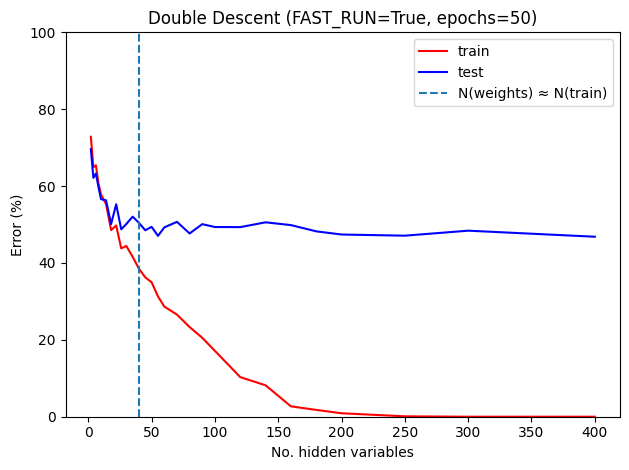

Saved: /content/double_descent_plot.png and double_descent_results.csv


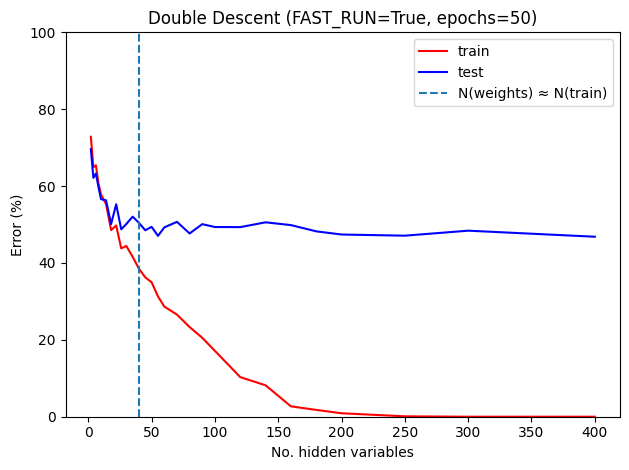

In [2]:
!pip install -q git+https://github.com/greydanus/mnist1d

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np, matplotlib.pyplot as plt, mnist1d, random, os

DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

# === Toggle ===
FAST_RUN = True
n_epoch = 50 if FAST_RUN else 1000

random.seed(0)
args = mnist1d.data.get_dataset_args()
args.num_samples = 8000
args.train_split = 0.5
args.corr_noise_scale = 0.25
args.iid_noise_scale = 2e-2
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=True)

for i in range(len(data['y'])):
    if random.random() < 0.15:
        data['y'][i] = int(random.random() * 10)

print("train/test/dim:", len(data['y']), len(data['y_test']), data['x'].shape[-1])

def weights_init(l):
    if isinstance(l, nn.Linear):
        nn.init.kaiming_uniform_(l.weight, nonlinearity='relu')
        l.bias.data.fill_(0.0)

def get_model(n):
    m = nn.Sequential(
        nn.Linear(40, n),
        nn.ReLU(),
        nn.Linear(n, n),
        nn.ReLU(),
        nn.Linear(n, 10)
    )
    m.apply(weights_init)
    return m

def fit_model(model, data, n_epoch):
    lossf = torch.nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    xtr = torch.tensor(data['x'].astype('float32'))
    ytr = torch.tensor(data['y'].astype('long'))
    xte = torch.tensor(data['x_test'].astype('float32'))
    yte = torch.tensor(data['y_test'].astype('long'))
    loader = DataLoader(TensorDataset(xtr, ytr), batch_size=100, shuffle=True)
    for _ in range(n_epoch):
        for xb, yb in loader:
            opt.zero_grad()
            loss = lossf(model(xb), yb)
            loss.backward()
            opt.step()
    with torch.no_grad():
        pt, pe = model(xtr), model(xte)
        etr = 100 - 100 * (torch.max(pt, 1)[1] == ytr).float().mean()
        ete = 100 - 100 * (torch.max(pe, 1)[1] == yte).float().mean()
    return float(etr), float(ete)

def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

hidden_variables = np.array([2,4,6,8,10,14,18,22,26,30,35,40,45,50,55,60,70,80,90,100,120,140,160,180,200,250,300,400])
errors_train_all = np.zeros_like(hidden_variables, float)
errors_test_all = np.zeros_like(hidden_variables, float)
total_weights_all = np.zeros_like(hidden_variables, int)

for i, h in enumerate(hidden_variables):
    print(f"Training model with {h} hidden units  (epoch x {n_epoch})")
    model = get_model(h)
    total_weights_all[i] = count_parameters(model)
    etr, ete = fit_model(model, data, n_epoch)
    errors_train_all[i], errors_test_all[i] = etr, ete

num_training_examples = len(data['y'])
closest_index = np.argmin(np.abs(total_weights_all - num_training_examples))
hidden_at_Neq = hidden_variables[closest_index]

fig, ax = plt.subplots()
ax.plot(hidden_variables, errors_train_all, 'r-', label='train')
ax.plot(hidden_variables, errors_test_all, 'b-', label='test')
ax.axvline(x=hidden_at_Neq, linestyle='--', label='N(weights) ≈ N(train)')
ax.set_ylim(0, 100)
ax.set_xlabel('No. hidden variables')
ax.set_ylabel('Error (%)')
ax.legend()
plt.title(f"Double Descent (FAST_RUN={FAST_RUN}, epochs={n_epoch})")
plt.tight_layout()
plt.show()

np.savetxt("double_descent_results.csv",
           np.vstack([hidden_variables, total_weights_all, errors_train_all, errors_test_all]).T,
           delimiter=",", header="hidden_units,total_params,train_error,test_error", comments="", fmt=["%d","%d","%.6f","%.6f"])

figpath = "double_descent_plot.png"
plt.figure()
plt.plot(hidden_variables, errors_train_all, 'r-', label='train')
plt.plot(hidden_variables, errors_test_all, 'b-', label='test')
plt.axvline(x=hidden_at_Neq, linestyle='--', label='N(weights) ≈ N(train)')
plt.ylim(0, 100)
plt.xlabel('No. hidden variables'); plt.ylabel('Error (%)'); plt.legend()
plt.title(f"Double Descent (FAST_RUN={FAST_RUN}, epochs={n_epoch})")
plt.tight_layout(); plt.savefig(figpath, dpi=150)
print("Saved:", os.path.abspath(figpath), "and double_descent_results.csv")
